In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import time
import math

In [2]:
# choose whether to study pickups or dropoffs

target = "pickup"
# target = "dropoff"

In [3]:
start = time.time()

filename = '-yellow_tripdata_2016-06.csv'
nlinesfile = 11135470 # total number of samples
nlinesrandomsample = 5000000 # set amount of data to import based on RAM capacity (reduce if you get out of memory errors)

# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html
skip = np.random.choice(np.arange(1,nlinesfile+1), (nlinesfile-nlinesrandomsample), replace=False)

df = pd.read_csv(filename, 
                 usecols=['tpep_pickup_datetime', 
                          'tpep_dropoff_datetime', 
                          'pickup_longitude', 
                          'pickup_latitude', 
                          'dropoff_longitude', 
                          'dropoff_latitude'],
                 skiprows=skip, 
                 error_bad_lines=False)

print "load file:", (time.time() - start), "sec"

load file: 24.4282460213 sec


In [4]:
print df[:5]

  tpep_pickup_datetime tpep_dropoff_datetime  pickup_longitude  \
0  2016-06-09 21:06:36   2016-06-09 21:13:10        -73.994316   
1  2016-06-09 21:06:36   2016-06-09 21:23:23        -73.987106   
2  2016-06-09 21:06:36   2016-06-09 21:30:13        -73.980476   
3  2016-06-09 21:06:37   2016-06-09 21:16:47        -73.985703   
4  2016-06-09 21:06:37   2016-06-09 21:23:57        -73.977921   

   pickup_latitude  dropoff_longitude  dropoff_latitude  
0        40.751072         -74.004234         40.742168  
1        40.733173         -73.985909         40.766445  
2        40.741680         -73.902962         40.748741  
3        40.746742         -73.982506         40.762772  
4        40.750092         -73.987236         40.749359  


In [5]:
# cull by geography (bounding box around manhattan)

print "starting entries:", len(df)

df = df[(df[target+'_latitude'] >= 40.699) & (df[target+'_latitude'] <= 40.875)]
df = df[(df[target+'_longitude'] >= -74.025) & (df[target+'_longitude'] <= -73.904)]

print "final entries:", len(df)

starting entries: 5000000
final entries: 4607383


In [6]:
# chunk geography by rounding latitude and logitude to 3 decimal places

df[target+'_longitude'] = df[target+'_longitude'].round(3)
df[target+'_latitude'] = df[target+'_latitude'].round(3)

In [7]:
# convert pickup and dropoff data to panda's datatime format

df['tpep_pickup_datetime'] =  pd.to_datetime(df['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
df['tpep_dropoff_datetime'] =  pd.to_datetime(df['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')

In [8]:
timeSeries = df['tpep_'+ target +'_datetime']

dow = timeSeries.dt.dayofweek
df[target+'_dow_s'] = dow.apply(lambda x: math.sin((2 * math.pi) / 7 * x))

tod = timeSeries.dt.hour
df[target+'_tod_s'] = tod.apply(lambda x: math.sin((2 * math.pi) / 24 * x))

In [9]:
print df[:5]

  tpep_pickup_datetime tpep_dropoff_datetime  pickup_longitude  \
0  2016-06-09 21:06:36   2016-06-09 21:13:10           -73.994   
1  2016-06-09 21:06:36   2016-06-09 21:23:23           -73.987   
2  2016-06-09 21:06:36   2016-06-09 21:30:13           -73.980   
3  2016-06-09 21:06:37   2016-06-09 21:16:47           -73.986   
4  2016-06-09 21:06:37   2016-06-09 21:23:57           -73.978   

   pickup_latitude  dropoff_longitude  dropoff_latitude  pickup_dow_s  \
0           40.751         -74.004234         40.742168      0.433884   
1           40.733         -73.985909         40.766445      0.433884   
2           40.742         -73.902962         40.748741      0.433884   
3           40.747         -73.982506         40.762772      0.433884   
4           40.750         -73.987236         40.749359      0.433884   

   pickup_tod_s  
0     -0.707107  
1     -0.707107  
2     -0.707107  
3     -0.707107  
4     -0.707107  


In [10]:
# group by features to get counts at areas of same geography and time
# http://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-object-to-dataframe
count_data = pd.DataFrame({'count' : df.groupby( [target+'_longitude', target+'_latitude', target+'_dow_s', target+'_tod_s'] ).size()}).reset_index()

print count_data[:5]
print 'number of samples:', len(count_data)
print 'min number of pickups in any sample:', count_data['count'].min()
print 'max number of pickups in any sample:', count_data['count'].max()

   pickup_longitude  pickup_latitude  pickup_dow_s  pickup_tod_s  count
0           -74.025           40.751     -0.974928      0.000000      1
1           -74.025           40.753      0.433884      0.000000      1
2           -74.025           40.763     -0.974928     -0.500000      1
3           -74.025           40.766      0.433884     -0.707107      1
4           -74.025           40.769      0.433884      0.707107      1
number of samples: 498706
min number of pickups in any sample: 1
max number of pickups in any sample: 499


In [11]:
# convert DataFrame to numpy array and shuffle it

data = count_data.as_matrix()
np.random.shuffle(data)

# create X (feature) and y (target) data sets

X = data[:,:-1]
y = data[:,-1]

print 'Data set:', X.shape, y.shape

Data set: (498706, 4) (498706,)


In [12]:
# use scikit-learn library to normalize x data to be mean 0, variance 1

import pickle
from sklearn import preprocessing

# fit scaling function to X data
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = preprocessing.StandardScaler().fit(X)

# save out scaling function for later use
with open("-scaler_"+target+".pkl", "wb") as f:
    pickle.dump(scaler, f)

# split data into training and test sets
# trainingSplit = int(.8 * data.shape[0])
# X_train = X[:trainingSplit]
# y_train = y[:trainingSplit]
# X_test = X[trainingSplit:]
# y_test = y[trainingSplit:]

# print 'Training set', X_train.shape, y_train.shape
# print 'Test set', X_test.shape, y_test.shape

# scale training and test data using scaling function
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.transform(X)

# check to make sure data was scaled correctly
# print "Training feature data -- mean:", X_train_scaled.mean(), "std:", X_train_scaled.std()
# print "Test feature data -- mean:", X_test_scaled.mean(), "std:", X_test_scaled.std()

print "mean:", X_scaled.mean(), "<-- should be around 0.0"
print "std:", X_scaled.std(), "<-- should be around 1.0"

mean: 8.3266535393e-15 <-- should be around 0.0
std: 1.0 <-- should be around 1.0


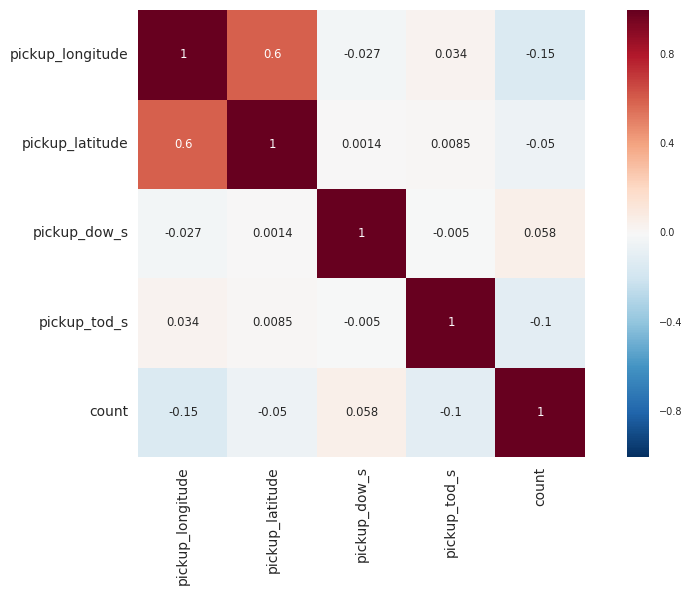

In [13]:
#plot correlation matrix between features and target

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = pd.DataFrame(data=X_scaled, columns=[target+'_longitude', target+'_latitude', target+'_dow_s', target+'_tod_s'])
corr_df['count'] = y

corrmat = corr_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn
sns.set_context("notebook", font_scale=0.7, rc={"lines.linewidth": 1.5})
sns.heatmap(corrmat, annot=True, square=True)
f.tight_layout()

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

# model hyperparameters
batch_size = 256
nb_epoch = 5

num_hidden_1 = 1024
num_hidden_2 = 1024
num_hidden_3 = 1024
dropout = 0.15

Using TensorFlow backend.


In [15]:
model = Sequential()

model.add(Dense(output_dim=num_hidden_1, input_dim=X.shape[1], W_regularizer=l2(0.0005)))
model.add(Activation("tanh"))
model.add(Dropout(dropout))
model.add(Dense(num_hidden_2, W_regularizer=l2(0.0005)))
model.add(Activation("tanh"))
model.add(Dropout(dropout))
model.add(Dense(num_hidden_3, W_regularizer=l2(0.0005)))
model.add(Activation("tanh"))
model.add(Dropout(dropout))
model.add(Dense(1)) # single neuron in output layer for regression problem

# save out model each time it performs better than previous epochs
checkpoint_name = "-model_"+target+".hdf5"
checkpointer = ModelCheckpoint(checkpoint_name, verbose=0, save_best_only=True)

# mean squared logarithmic error for regression problme
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

# fit model using a 20% validation split (keras will automatically split the data into training and validation sets)
history = model.fit(X_scaled, y, validation_split=0.2, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, callbacks=[checkpointer])

Train on 398964 samples, validate on 99742 samples
Epoch 1/5
398964/398964 [==============================] - 211s - loss: 0.9546 - val_loss: 0.7579
Epoch 2/5
398964/398964 [==============================] - 199s - loss: 0.7928 - val_loss: 0.7394
Epoch 3/5
398964/398964 [==============================] - 217s - loss: 0.7895 - val_loss: 0.7412
Epoch 4/5
398964/398964 [==============================] - 187s - loss: 0.7889 - val_loss: 0.7383
Epoch 5/5
398964/398964 [==============================] - 176s - loss: 0.7875 - val_loss: 0.7334


In [16]:
# list all data in history

print(history.history.keys())

['loss', 'val_loss']


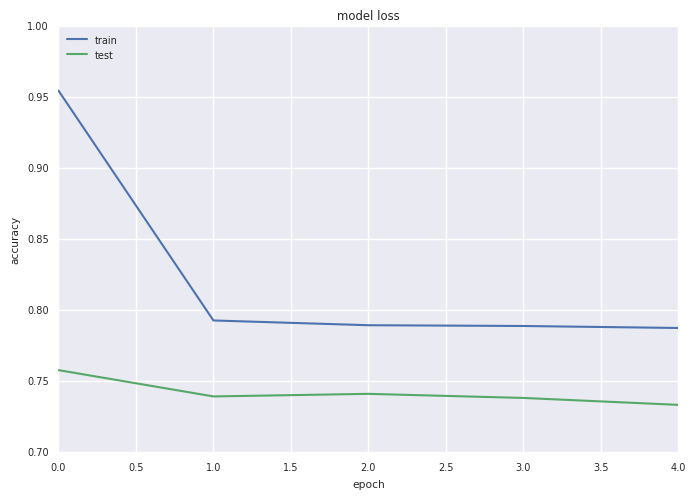

In [17]:
# plot history of loss in training and validation data

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()